In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import bct
from os import makedirs
from matplotlib.colors import LinearSegmentedColormap
from os.path import join, exists
from nilearn.plotting import plot_glass_brain, plot_roi, find_parcellation_cut_coords
#import bct
import datetime
from nilearn.mass_univariate import permuted_ols
from scipy.stats import pearsonr, spearmanr
sns.set_context('poster', font_scale=0.85)
import matplotlib.pyplot as plt


In [3]:

def jili_sidak_mc(data, alpha):
    import math
    import numpy as np

    mc_corrmat = data.corr()
    mc_corrmat.fillna(0, inplace=True)
    eigvals, eigvecs = np.linalg.eig(mc_corrmat)

    M_eff = 0
    for eigval in eigvals:
        if abs(eigval) >= 0:
            if abs(eigval) >= 1:
                M_eff += 1
            else:
                M_eff += abs(eigval) - math.floor(abs(eigval))
        else:
            M_eff += 0
    print('Number of effective comparisons: {0}'.format(M_eff))

    #and now applying M_eff to the Sidak procedure
    sidak_p = 1 - (1 - alpha)**(1/M_eff)
    if sidak_p < 0.00001:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:2e} after corrections'.format(sidak_p))
    else:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:.6f} after corrections'.format(sidak_p))
    return sidak_p, M_eff


In [4]:


# In[3]:


subjects = ['101', '102', '103', '104', '106', '107', '108', '110', '212', '213',
            '214', '215', '216', '217', '218', '219', '320', '321', '322', '323',
            '324', '325', '327', '328', '329', '330', '331', '332', '333', '334',
            '335', '336', '337', '338', '339', '340', '341', '342', '343', '344',
            '345', '346', '347', '348', '349', '350', '451', '452', '453', '455',
            '456', '457', '458', '459', '460', '462', '463', '464', '465', '467',
            '468', '469', '470', '502', '503', '571', '572', '573', '574', '575',
            '577', '578', '579', '580', '581', '582', '584', '585', '586', '587',
            '588', '589', '590', '591', '592', '593', '594', '595', '596', '597',
            '598', '604', '605', '606', '607', '608', '609', '610', '611', '612',
            '613', '614', '615', '616', '617', '618', '619', '620', '621', '622',
            '623', '624', '625', '626', '627', '628', '629', '630', '631', '633',
            '634']
#subjects = ['101', '102']

sink_dir = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output'
data_dir = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/data'
roi_dir = '/Users/kbottenh/Dropbox/Data/templates/shen2015/'
fig_dir = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/figures/'

shen = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/shen2015_2mm_268_parcellation.nii.gz'
craddock = '/home/kbott006/physics-retrieval/craddock2012_tcorr05_2level_270_2mm.nii.gz'
masks = ['shen2015', 'craddock2012']

tasks = {'retr': [{'conditions': ['Physics', 'General']},
                  {'runs': [0,1]}], 
         'fci': [{'conditions': ['Physics', 'NonPhysics']},
                  {'runs': [0,1,2]}]}

sessions = [0,1]

colors = sns.blend_palette(['#ec407a', '#ff7043', '#ffca28',
                            '#d4e157', '#66bb6a', '#26c6da',
                            '#42a5f5', '#7e57c2'], 
                           n_colors=268, as_cmap=True)



# Data wrangling
Nodal efficiency data is currently in an <i>incredbily</i> long, multi-indexed dataframe. Here, we transform it into wide data (dataframe per condition per task per session) for ease of analysis later.

In [26]:

# # Data wrangling
# Nodal efficiency data is currently in an <i>incredbily</i> long, multi-indexed dataframe. 
# Here, we transform it into wide data (dataframe per condition per task per session) for ease of analysis later.


df = pd.read_csv(join(data_dir, 'physics-learning-tasks_graphtheory_shen+craddock_nodal.csv'), index_col=0, header=0)
df.rename({'Unnamed: 1': 'session', 'Unnamed: 2': 'task', 'Unnamed: 3': 'condition'}, axis=1, inplace=True)
null_df = pd.read_csv(join(sink_dir, 'local_efficiency', 'task_eff_dist.csv'), 
                      index_col=[0,1,2,3], header=0)

for i in np.arange(0,268)[::-1] :
    df.rename({'lEff{0}'.format(i): 'lEff{0}'.format(i+1)}, axis=1, inplace=True)
j = list(set(df.columns) - set(['session', 'task', 'condition', 'mask']))
j.sort()
conns = j

big_df = pd.read_csv(join(data_dir, 'rescored', 'non-brain-data+fd.csv'), index_col=0, header=0)

shen2015
pre-instruction knowledge, phys > control:	 -6.777175126773729
post-instruction knowledge, phys > control:	 0.8675325439253514
pre-instruction reasoning, phys > control:	 6.539902489303306
post-instruction reasoning, phys > control:	 19.85223330349856


physics knowledge, post > pre:	 -6.7619371597330975
general knowledge, post > pre:	 -17.846696331767642
physics fci, post > pre:	 23.776984936314427
general fci, post > pre:	 32.746678011331404
post phys fci
deltaPRI
post phys fci deltaPRI max p-val: 0.9201389596101419
# significant nodes: 0
post phys fci deltaPRIXSex max p-val: 0.37679413687896224
# significant nodes: 0
post phys fci deltaPRIXClass max p-val: 1.3872595705571271
# significant nodes: 1
post phys fci deltaPRIXClassXSex max p-val: 0.6749384443054552
# significant nodes: 0
post phys fci F max p-val: 0.5007688453846453
# significant nodes: 0
post phys fci Strt.Level max p-val: 0.06950189741242825
# significant nodes: 0
post phys fci SexXClass max p-val: 0.7739593113

/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


1 ('deltaPRI', 'post phys fci', 'iqXclass')
87 1.0


/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)


2 ('deltaPRI', 'post phys fci', 'fd')
11 2.0
118 2.0
122 2.0
123 2.0
127 2.0
128 2.0
15 2.0
158 2.0
159 2.0
161 2.0
163 2.0
168 2.0
170 2.0
173 2.0
174 2.0
218 2.0
226 2.0
23 2.0
24 2.0
242 2.0
248 2.0
258 2.0
259 2.0
264 2.0
35 2.0
40 2.0
44 2.0
61 2.0
77 2.0
84 2.0
88 2.0
89 2.0
91 2.0
3 ('deltaFSIQ', 'post phys fci', 'fd')
108 3.0
109 3.0
11 3.0
118 3.0
122 3.0
123 3.0
127 3.0
128 3.0
142 3.0
15 3.0
158 3.0
159 3.0
161 3.0
163 3.0
168 3.0
170 3.0
171 3.0
173 3.0
174 3.0
191 3.0
20 3.0
216 3.0
218 3.0
220 3.0
226 3.0
23 3.0
236 3.0
24 3.0
240 3.0
242 3.0
248 3.0
258 3.0
259 3.0
260 3.0
263 3.0
264 3.0
27 3.0
28 3.0
35 3.0
40 3.0
44 3.0
46 3.0
61 3.0
67 3.0
7 3.0
77 3.0
84 3.0
88 3.0
89 3.0
91 3.0
4 ('WMI2', 'post phys retr', 'sexXclass')
127 4.0
5 ('VCI2', 'post phys retr', 'Mod')
189 5.0
6 ('VCI2', 'post phys retr', 'fd')
1 6.0
11 6.0
188 6.0
20 6.0
227 6.0
34 6.0
5 6.0
50 6.0
('deltaPRI', 'post phys fci', 'iqXclass') 0
['lEff87']
('deltaPRI', 'post phys fci', 'fd') 1
['lEff11', 'lE

/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


deltaPRI
post phys fci deltaPRI max p-val: 0.9136835966021144
# significant nodes: 0
post phys fci deltaPRIXSex max p-val: 1.1911575599170505
# significant nodes: 1
post phys fci deltaPRIXClass max p-val: 0.7706175793561677
# significant nodes: 0
post phys fci deltaPRIXClassXSex max p-val: 0.9859431057572421
# significant nodes: 0
post phys fci F max p-val: 0.138091052355411
# significant nodes: 0
post phys fci Strt.Level max p-val: 0.16958307724589552
# significant nodes: 0
post phys fci SexXClass max p-val: 0.04143176951198326
# significant nodes: 0
post phys fci Age max p-val: 0.07298118378386263
# significant nodes: 0
post phys fci Mod max p-val: 0.017003811230760692
# significant nodes: 0
post phys fci post phys fci fd max p-val: 1.335401451720737
# significant nodes: 24
deltaFSIQ
post phys fci deltaFSIQ max p-val: 0.5386949936288797
# significant nodes: 0
post phys fci deltaFSIQXSex max p-val: 0.6334337168844331
# significant nodes: 0
post phys fci deltaFSIQXClass max p-val: 0.54

/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


1 ('deltaPRI', 'post phys fci', 'iq')
28 1.0


/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)


2 ('deltaPRI', 'post phys fci', 'iqXsex')
28 2.0
3 ('deltaPRI', 'post phys fci', 'fd')
10 3.0
116 3.0
124 3.0
141 3.0
171 3.0
177 3.0
179 3.0
210 3.0
222 3.0
223 3.0
241 3.0
256 3.0
26 3.0
262 3.0
263 3.0
265 3.0
266 3.0
29 3.0
3 3.0
5 3.0
64 3.0
69 3.0
74 3.0
76 3.0
4 ('deltaFSIQ', 'post phys fci', 'fd')
10 4.0
111 4.0
116 4.0
124 4.0
141 4.0
146 4.0
149 4.0
157 4.0
171 4.0
177 4.0
179 4.0
187 4.0
199 4.0
2 4.0
210 4.0
216 4.0
220 4.0
222 4.0
223 4.0
233 4.0
239 4.0
241 4.0
248 4.0
256 4.0
257 4.0
26 4.0
262 4.0
263 4.0
265 4.0
266 4.0
29 4.0
3 4.0
33 4.0
42 4.0
5 4.0
64 4.0
69 4.0
74 4.0
76 4.0
85 4.0
94 4.0
5 ('VCI2', 'post phys retr', 'fd')
10 5.0
101 5.0
102 5.0
110 5.0
119 5.0
124 5.0
129 5.0
136 5.0
141 5.0
159 5.0
171 5.0
181 5.0
183 5.0
186 5.0
194 5.0
205 5.0
22 5.0
225 5.0
227 5.0
23 5.0
237 5.0
248 5.0
250 5.0
264 5.0
3 5.0
41 5.0
42 5.0
6 5.0
62 5.0
76 5.0
87 5.0
('deltaPRI', 'post phys fci', 'iq') 0
['lEff28']
('deltaPRI', 'post phys fci', 'iqXsex') 1
['lEff28']
('deltaPR

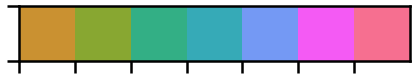

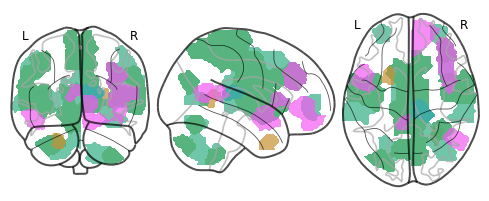

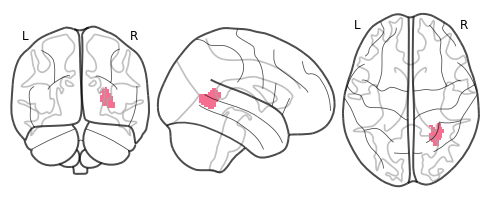

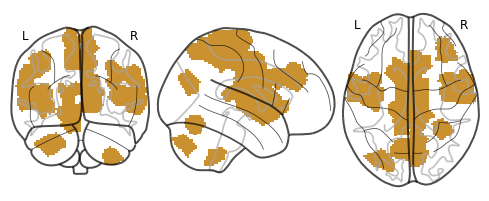

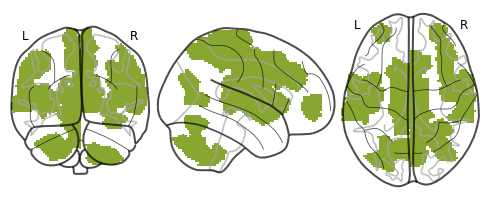

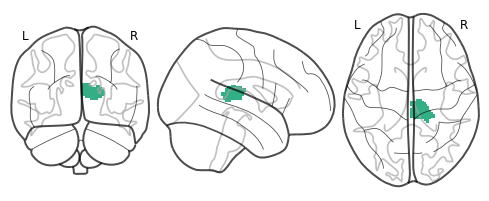

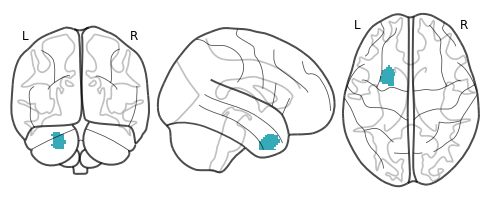

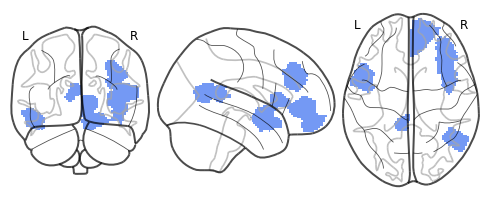

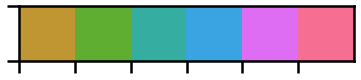

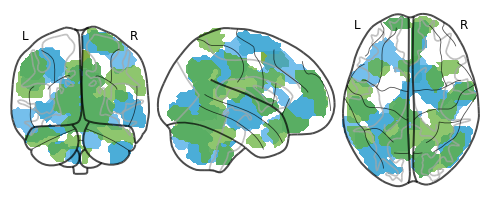

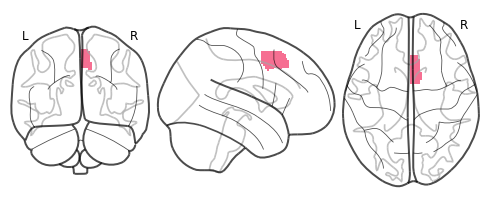

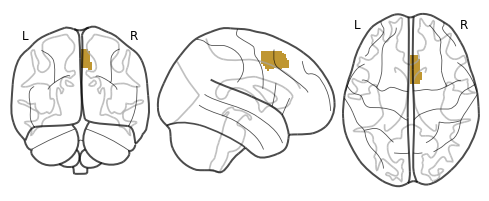

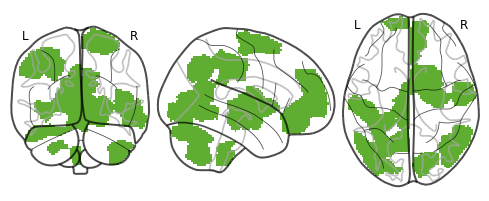

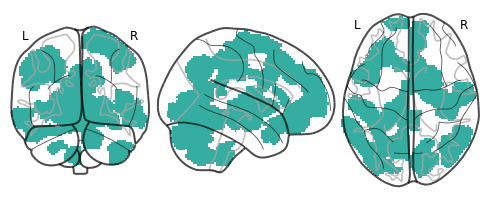

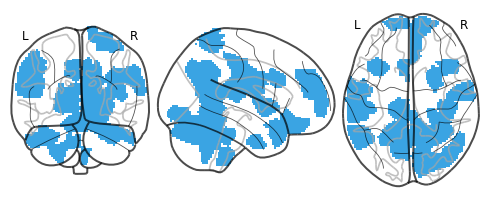

In [34]:
for mask in masks:
    print(mask)
    fci_df = df[df['mask'] == mask]
    fci_df = fci_df[fci_df['task'] == 'fci']
    fci_pre = fci_df[fci_df['session'] == 0]
    fci_pre_phys = fci_pre[fci_pre['condition'] == 'high-level']
    fci_pre_ctrl = fci_pre[fci_pre['condition'] == 'lower-level']
    fci_post = fci_df[fci_df['session'] == 1]
    fci_post_phys = fci_post[fci_post['condition'] == 'high-level']
    fci_post_ctrl = fci_post[fci_post['condition'] == 'lower-level']

    retr_df = df[df['mask'] == mask]
    retr_df = retr_df[retr_df['task'] == 'retr']
    retr_pre = retr_df[retr_df['session'] == 0]
    retr_pre_phys = retr_pre[retr_pre['condition'] == 'high-level']
    retr_pre_ctrl = retr_pre[retr_pre['condition'] == 'lower-level']
    retr_post = retr_df[retr_df['session'] == 1]
    retr_post_phys = retr_post[retr_post['condition'] == 'high-level']
    retr_post_ctrl = retr_post[retr_post['condition'] == 'lower-level']

    fci_pre_phys.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)
    fci_post_phys.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)

    fci_pre_ctrl.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)
    fci_post_ctrl.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)

    retr_pre_phys.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)
    retr_post_phys.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)

    retr_pre_ctrl.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)
    retr_post_ctrl.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)

    pre_retr_phys_mean = null_df.loc['pre', 'retr', 'physics', mask]['mean']
    pre_retr_ctrl_mean = null_df.loc['pre', 'retr', 'control', mask]['mean']

    pre_retr_phys_sdev = null_df.loc['pre', 'retr', 'physics', mask]['sdev']
    pre_retr_ctrl_sdev = null_df.loc['pre', 'retr', 'control', mask]['sdev']

    post_retr_phys_mean = null_df.loc['post', 'retr', 'physics', mask]['mean']
    post_retr_ctrl_mean = null_df.loc['post', 'retr', 'control', mask]['mean']

    post_retr_phys_sdev = null_df.loc['post', 'retr', 'physics', mask]['sdev']
    post_retr_ctrl_sdev = null_df.loc['post', 'retr', 'control', mask]['sdev']

    pre_fci_phys_mean = null_df.loc['pre', 'fci', 'physics', mask]['mean']
    pre_fci_ctrl_mean = null_df.loc['pre', 'fci', 'control', mask]['mean']

    pre_fci_phys_sdev = null_df.loc['pre', 'fci', 'physics', mask]['sdev']
    pre_fci_ctrl_sdev = null_df.loc['pre', 'fci', 'control', mask]['sdev']

    post_fci_phys_mean = null_df.loc['post', 'fci', 'physics', mask]['mean']
    post_fci_ctrl_mean = null_df.loc['post', 'fci', 'control', mask]['mean']

    post_fci_phys_sdev = null_df.loc['post', 'fci', 'physics', mask]['sdev']
    post_fci_ctrl_sdev = null_df.loc['post', 'fci', 'control', mask]['sdev']


    #compare null distributions across task condition
    pre_retr_phys_ctrl = (pre_retr_phys_mean - pre_retr_ctrl_mean) / np.sqrt((pre_retr_phys_sdev ** 2) + (pre_retr_ctrl_sdev ** 2))
    print('pre-instruction knowledge, phys > control:\t', pre_retr_phys_ctrl)
    post_retr_phys_ctrl = (post_retr_phys_mean - post_retr_ctrl_mean) / np.sqrt((post_retr_phys_sdev ** 2) + (post_retr_ctrl_sdev ** 2))
    print('post-instruction knowledge, phys > control:\t', post_retr_phys_ctrl)


    pre_fci_phys_ctrl = (pre_fci_phys_mean - pre_fci_ctrl_mean) / np.sqrt((pre_fci_phys_sdev ** 2) + (pre_fci_ctrl_sdev ** 2))
    print('pre-instruction reasoning, phys > control:\t', pre_fci_phys_ctrl)
    post_fci_phys_ctrl = (post_fci_phys_mean - post_fci_ctrl_mean) / np.sqrt((post_fci_phys_sdev ** 2) + (post_fci_ctrl_sdev ** 2))
    print('post-instruction reasoning, phys > control:\t', post_fci_phys_ctrl)

    #compare null distributions across time
    print('\n')
    retr_phys = (post_retr_phys_mean - pre_retr_phys_mean) / np.sqrt((pre_retr_phys_sdev ** 2) + (post_retr_phys_sdev ** 2))
    print('physics knowledge, post > pre:\t', retr_phys)
    retr_ctrl = (post_retr_ctrl_mean - pre_retr_ctrl_mean) / np.sqrt((pre_retr_ctrl_sdev ** 2) + (post_retr_ctrl_sdev ** 2))
    print('general knowledge, post > pre:\t', retr_ctrl)

    fci_phys = (post_fci_phys_mean - pre_fci_phys_mean) / np.sqrt((pre_fci_phys_sdev ** 2) + (post_fci_phys_sdev ** 2))
    print('physics fci, post > pre:\t', fci_phys)
    fci_ctrl = (post_fci_ctrl_mean - pre_fci_ctrl_mean) / np.sqrt((pre_fci_ctrl_sdev ** 2) + (post_fci_ctrl_sdev ** 2))
    print('general fci, post > pre:\t', fci_ctrl)


    #standardize against the empirical null distribution!
    fci_pre_phys[conns] = fci_pre_phys[conns] / null_df.loc['pre', 'fci', 'physics', mask]['mean']
    retr_pre_phys[conns] = retr_pre_phys[conns] / null_df.loc['pre', 'retr', 'physics', mask]['mean']
    #rest_pre[conns] = (rest_pre[conns] - rest_pre[conns].mean()) / rest_pre[conns].std()
    fci_post_phys[conns] = fci_post_phys[conns] / null_df.loc['post', 'fci', 'physics', mask]['mean']
    retr_post_phys[conns] = retr_post_phys[conns] / null_df.loc['post', 'retr', 'physics', mask]['mean']
    #rest_post[conns] = (rest_post[conns] - rest_post[conns].mean()) / rest_post[conns].std()


    effs = {'post phys fci': {'conns': fci_post_phys, 'iqs': ['deltaPRI', 'deltaFSIQ']},
            'post phys retr': {'conns': retr_post_phys, 'iqs': ['WMI2', 'VCI2']}}
    iqs = effs['post phys fci']['iqs'] + effs['post phys retr']['iqs']
    variables = ['iq', 'iqXsex', 'iqXclass', 'iqXsexXclass', 'sexXclass', 'F', 'Mod', 'Age', 'Strt.Level', 'fd']


    # # Regress local efficiency on IQ and all the covariates
    # Permuted OLS tests each `target_var` independently, while regressing out `confounding_vars`, so to run a multiple regression, we test each variable of interest, separately, and put all other variables in the regression in with the confounds. This way, we can test interactions <i>with</i> main effects.
    # <br><br>
    # Maximum p-values are saved in `sig` dictionary and for each significant variable, the p- and t-values for each node are saved in `nodaleff_sig`.
    # <br><br>
    # For each regression, maximum <i>p</i>- and <i>t</i>-values are stored in `params`, along with nodes whose local efficiency is significantly related to each parameter, are stored <i> by variable</i>.


    sig = {}
    nodaleff_sig = pd.DataFrame(index=conns)
    index = pd.MultiIndex.from_product([iqs, effs.keys(), variables])
    params = pd.DataFrame(index=index, columns=['max nlog(p)', 'max t', 'nodes'])


    for key in effs.keys():
        print(key)
        efficiency = effs[key]['conns']
        iqs = effs[key]['iqs']
        all_data = pd.concat([big_df, efficiency], axis=1)
        all_data.dropna(how='any', axis=0, inplace=True)
        all_data[conns] = (all_data[conns] - all_data[conns].mean()) / all_data[conns].std()
        for iq in iqs:
            print(iq)
            specvars = ['{0}'.format(iq), '{0}XSex'.format(iq), '{0}XClass'.format(iq), 
                        '{0}XClassXSex'.format(iq),
                        'F', 'Strt.Level', 'SexXClass', 'Age', 'Mod', '{0} fd'.format(key)]
            for var in specvars:
                covariates = list(set(specvars) - set([var]))
                p, t, _ = permuted_ols(all_data[var], 
                                    all_data[conns], 
                                    all_data[covariates],
                                    n_perm=10000)
                print(key, var, 'max p-val:',  np.max(p[0]))
                sig['{0}, {1}'.format(iq, key)] = np.max(p[0])
                nodaleff_sig['{0} {1} p'.format(iq, key)] = p.T
                nodaleff_sig['{0} {1} t'.format(iq, key)] = t.T
                sig_nodes = nodaleff_sig[nodaleff_sig['{0} {1} p'.format(iq, key)] >= 1].index
                print('# significant nodes:', len(sig_nodes))
                if key in var:
                    params.loc[iq, key, 'fd']['max nlog(p)'] = np.max(p[0])
                    params.loc[iq, key, 'fd']['max t'] = np.max(t[0])
                    params.loc[iq, key, 'fd']['nodes'] = list(sig_nodes)
                elif iq in var:
                    if 'Sex' in var:
                        if 'Class' in var:
                            params.loc[iq, key, 'iqXsexXclass']['max nlog(p)'] = np.max(p[0])
                            params.loc[iq, key, 'iqXsexXclass']['max t'] = np.max(t[0])
                            params.loc[iq, key, 'iqXsexXclass']['nodes'] = list(sig_nodes)
                        else:
                            params.loc[iq, key, 'iqXsex']['max nlog(p)'] = np.max(p[0])
                            params.loc[iq, key, 'iqXsex']['max t'] = np.max(t[0])
                            params.loc[iq, key, 'iqXsex']['nodes'] = list(sig_nodes)
                    if 'Class' in var:
                        if not 'Sex' in var:
                            params.loc[iq, key, 'iqXclass']['max nlog(p)'] = np.max(p[0])
                            params.loc[iq, key, 'iqXclass']['max t'] = np.max(t[0])
                            params.loc[iq, key, 'iqXclass']['nodes'] = list(sig_nodes)
                    else:
                        params.loc[iq, key, 'iq']['max nlog(p)'] = np.max(p[0])
                        params.loc[iq, key, 'iq']['max t'] = np.max(t[0])
                        params.loc[iq, key, 'iq']['nodes'] = list(sig_nodes)
                elif var == 'SexXClass':
                    params.loc[iq, key, 'sexXclass']['max nlog(p)'] = np.max(p[0])
                    params.loc[iq, key, 'sexXclass']['max t'] = np.max(t[0])
                    params.loc[iq, key, 'sexXclass']['nodes'] = list(sig_nodes)
                else:
                    params.loc[iq, key, var]['max nlog(p)'] = np.max(p[0])
                    params.loc[iq, key, var]['max t'] = np.max(t[0])
                    params.loc[iq, key, var]['nodes'] = list(sig_nodes)


    params.dropna(how='all', inplace=True)


    nodaleff_sig.to_csv(join(sink_dir, '{0}_local_efficiency_iq_sig_all.csv'.format(mask)))
    params.to_csv(join(sink_dir, '{0}_local_efficiency_iq_sig-nodes.csv'.format(mask)))


    n_map = int(len(params[params['max nlog(p)'] > 1].index)) + 1
    interval = 1 / n_map
    husl_pal = sns.husl_palette(n_colors=n_map, h=interval)
    husl_cmap = LinearSegmentedColormap.from_list(husl_pal, husl_pal, N=n_map)
    sns.palplot(husl_pal)

    crayons_l = sns.crayon_palette(['Vivid Tangerine', 'Cornflower'])
    crayons_d = sns.crayon_palette(['Brick Red', 'Midnight Blue'])
    grays = sns.light_palette('#999999', n_colors=3, reverse=True)

    f_2 = sns.crayon_palette(['Red Orange', 'Vivid Tangerine'])
    m_2 = sns.crayon_palette(['Cornflower', 'Cerulean'])


    # In[58]:


    empty_nii = nib.load(join(roi_dir, 'roi101.nii.gz'))
    empty_roi = empty_nii.get_fdata() * 0
    empty = nib.Nifti1Image(empty_roi, empty_nii.affine)
    g = plot_glass_brain(empty, colorbar=False, vmin=0.5, vmax=n_map)
    i = 0


    for var in params.index:
        if params.loc[var]['max nlog(p)'] > 1:
            i += 1
            husl_pal = sns.husl_palette(h=interval * i, n_colors=n_map)
            rois = None
            print(i, var)
            corr_nodes = []
            #tvals = params.loc[i]['max t']
            nodes = params.loc[var]['nodes']
            corr_nodes.append(int(nodes[0].strip('lEff')))
            roi_nifti = nib.load(join(roi_dir,'roi{0}.nii.gz'.format(int(nodes[0].strip('lEff')))))
            roi = roi_nifti.get_fdata()
            rois = (roi * i)
            print(int(nodes[0].strip('lEff')), np.max(rois))
            if len(nodes) > 1:
                for node in nodes[1:]:
                    corr_nodes.append(int(node.strip('lEff')))
                    roi_nifti = nib.load(join(roi_dir,'roi{0}.nii.gz'.format(int(node.strip('lEff')))))
                    roi = roi_nifti.get_fdata()
                    rois += (roi * i)
                    print(int(node.strip('lEff')), np.max(rois))
            else:
                pass
            np.savetxt(join(fig_dir, '{0}-{1}-{2}-.txt'.format(mask, i, var)), corr_nodes, delimiter=',')
            rois_nifti = nib.Nifti1Image(rois, roi_nifti.affine)
            rois_nifti.to_filename(join(data_dir, 'output/local_efficiency', '{0}_nodes.nii.gz'.format(var)))
            h = plot_glass_brain(rois_nifti, cmap=LinearSegmentedColormap.from_list(husl_pal, husl_pal, N=3))
            h.savefig(join(fig_dir, '{0}-{1}-{2}-_ROIs.png'.format(mask, i, var)), dpi=300)
            
            husl_pal = sns.husl_palette(n_colors=int(n_map), h=interval*i)
            g.add_contours(rois_nifti, colors=husl_pal, filled=True, alpha=0.7)
            
        else:
            pass
        
    g.savefig(join(fig_dir, '{0}-LEffXIQ_ROIs.png'.format(mask)), dpi=300)

    husl_pal = sns.husl_palette(n_colors=int(n_map))
    husl_cmap = LinearSegmentedColormap.from_list(husl_pal, husl_pal, N=int(n_map))
    i = 0
    for var in params.index:
        if params.loc[var]['max nlog(p)'] > 1:
            iq = var[0]
            task = var[1]
            dat = effs[task]['conns']
            husl_pal = sns.husl_palette(h=(interval*i), n_colors=int(n_map))

            print(var, i)
            all_data = pd.concat([big_df, dat[conns]], axis=1)
            all_data.dropna(how='any', axis=0, inplace=True)
            nodes = params.loc[var]['nodes']
            print(nodes)
            for node in nodes:
                if var[-1] == 'iqXsex':
                    #print(iq, 'x Sex', node, nodaleff_sig.at[node,'{0}t'.format(var[:-1])])
                    h = sns.lmplot(iq, node, data=all_data, hue='F', palette=crayons_d)
                    h.savefig(join(fig_dir, '{0}-{1}-{2}-scatter.png'.format(mask, var, node)), dpi=300)
                    plt.close()
                elif var[-1] == 'iqXsexXclass':
                    #print(iq, 'x Sex x Class', node,  nodaleff_sig.at[node,'{0}t'.format(var[:-1])])
                    h = sns.lmplot(iq, node, data=all_data[all_data['F'] == 1], hue='Mod', palette=f_2)
                    h.savefig(join(fig_dir, '{0}-{1}-{2}-scatter-f.png'.format(mask, var, node)), dpi=300)
                    h = sns.lmplot(iq, node, data=all_data[all_data['F'] == 0], hue='Mod', palette=m_2)
                    h.savefig(join(fig_dir, '{0}-{1}-{2}-scatter-m.png'.format(mask, var, node)), dpi=300)
                    plt.close()
                elif var[-1] == 'iqXclass':
                    #print(iq, 'x Class', node,  nodaleff_sig.at[node,'{0}t'.format(column[:-1])])
                    h = sns.lmplot(iq, node, data=all_data, hue='Mod', palette=grays)
                    h.savefig(join(fig_dir, '{0}-{1}-{2}-scatter.png'.format(mask, var, node)), dpi=300)
                    plt.close()
                elif var[-1] == 'sexXclass':
                    #print('Sex x Class', node,  nodaleff_sig.at[node,'{0}t'.format(column[:-1])])
                    h = sns.lmplot('F', node, data=all_data[all_data['F'] == 1], hue='Mod', palette=f_2)
                    h.savefig(join(fig_dir, '{0}-{1}-{2}-scatter-.png'.format(mask, var, node)), dpi=300)
                    plt.close()
                elif var[-1] == 'iq':
                    #print('no interxn', iq, node, nodaleff_sig.at[node,'{0}t'.format(column[:-1])])
                    fig,ax = plt.subplots()
                    sns.regplot(all_data[iq], all_data[node], color=husl_pal[0])
                    sns.despine()
                    plt.tight_layout()
                    fig.savefig(join(fig_dir, '{0}-{1}-{2}-scatter.png'.format(mask, var, node)), dpi=300)
                    plt.close()
                elif var[-1] == 'fd':
                    pass
                else:
                    fig,ax = plt.subplots()
                    sns.regplot(all_data[var[-1]], all_data[node], color=husl_pal[0])
                    sns.despine()
                    plt.tight_layout()
                    fig.savefig(join(fig_dir, '{0}-{1}-{2}-scatter.png'.format(mask, var, node)), dpi=300)
                    plt.close()
            i += 1

# %%


In [31]:
params

max nlog(p) max t nodes
deltaPRI post phys fci  deltaPRI                   NaN   NaN   NaN
                        deltaPRIXSex               NaN   NaN   NaN
                        deltaPRIXClass             NaN   NaN   NaN
                        deltaPRIXClassXSex         NaN   NaN   NaN
                        F                          NaN   NaN   NaN
...                                                ...   ...   ...
VCI2     post phys retr Strt.Level                 NaN   NaN   NaN
                        SexXClass                  NaN   NaN   NaN
                        Age                        NaN   NaN   NaN
                        Mod                        NaN   NaN   NaN
                        post phys fci fd           NaN   NaN   NaN

[80 rows x 3 columns]

In [9]:
j = list(set(shen_df.columns) - set(['session', 'task', 'condition', 'mask']))
j.sort()
conns = j[268:]

In [11]:
big_df = pd.read_csv(join(data_dir, 'rescored', 'non-brain-data+fd.csv'), index_col=0, header=0)

In [12]:
fci_shen = shen_df[shen_df['mask'] == 'shen2015']
fci_shen = fci_shen[fci_shen['task'] == 'fci']
fci_shen_pre = fci_shen[fci_shen['session'] == 0]
fci_shen_pre_phys = fci_shen_pre[fci_shen_pre['condition'] == 'high-level']
fci_shen_pre_ctrl = fci_shen_pre[fci_shen_pre['condition'] == 'lower-level']
fci_shen_post = fci_shen[fci_shen['session'] == 1]
fci_shen_post_phys = fci_shen_post[fci_shen_post['condition'] == 'high-level']
fci_shen_post_ctrl = fci_shen_post[fci_shen_post['condition'] == 'lower-level']

In [13]:
retr_shen = shen_df[shen_df['mask'] == 'shen2015']
retr_shen = retr_shen[retr_shen['task'] == 'retr']
retr_shen_pre = retr_shen[retr_shen['session'] == 0]
retr_shen_pre_phys = retr_shen_pre[retr_shen_pre['condition'] == 'high-level']
retr_shen_pre_ctrl = retr_shen_pre[retr_shen_pre['condition'] == 'lower-level']
retr_shen_post = retr_shen[retr_shen['session'] == 1]
retr_shen_post_phys = retr_shen_post[retr_shen_post['condition'] == 'high-level']
retr_shen_post_ctrl = retr_shen_post[retr_shen_post['condition'] == 'lower-level']

In [14]:
fci_shen_pre_phys.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)
fci_shen_post_phys.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)

fci_shen_pre_ctrl.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)
fci_shen_post_ctrl.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)

retr_shen_pre_phys.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)
retr_shen_post_phys.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)

retr_shen_pre_ctrl.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)
retr_shen_post_ctrl.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)

In [15]:
for i in np.arange(0,268)[::-1] :
    fci_shen_post_phys.rename({'lEff{0}'.format(i): 'lEff{0}'.format(i+1)}, axis=1, inplace=True)
    fci_shen_pre_phys.rename({'lEff{0}'.format(i): 'lEff{0}'.format(i+1)}, axis=1, inplace=True)
    retr_shen_post_phys.rename({'lEff{0}'.format(i): 'lEff{0}'.format(i+1)}, axis=1, inplace=True)
    retr_shen_pre_phys.rename({'lEff{0}'.format(i): 'lEff{0}'.format(i+1)}, axis=1, inplace=True)

/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
null_df = pd.read_csv(join(sink_dir, 'local_efficiency', 'task_eff_dist.csv'), 
                      index_col=[0,1,2,3], header=0)
null_df

mean          sdev
pre  retr physics shen2015      0.025129  7.743451e-05
                  craddock2012  0.026458  2.490053e-06
          control shen2015      0.025823  6.703095e-05
                  craddock2012  0.027278  2.041168e-05
     fci  physics shen2015      0.025062  3.275987e-05
                  craddock2012  0.026375  3.254526e-05
          control shen2015      0.024808  2.077373e-05
                  craddock2012  0.026232  7.526455e-07
post retr physics shen2015      0.024517  4.681676e-05
                  craddock2012  0.025867  1.937282e-05
          control shen2015      0.024465  3.591261e-05
                  craddock2012  0.025846  3.061520e-05
     fci  physics shen2015      0.026247  3.756711e-05
                  craddock2012  0.027542  4.321729e-05
          control shen2015      0.025498  3.495736e-06
                  craddock2012  0.026741  2.554834e-05

In [17]:
pre_retr_phys_mean = null_df.loc['pre', 'retr', 'physics', 'shen2015']['mean']
pre_retr_ctrl_mean = null_df.loc['pre', 'retr', 'control', 'shen2015']['mean']

pre_retr_phys_sdev = null_df.loc['pre', 'retr', 'physics', 'shen2015']['sdev']
pre_retr_ctrl_sdev = null_df.loc['pre', 'retr', 'control', 'shen2015']['sdev']

post_retr_phys_mean = null_df.loc['post', 'retr', 'physics', 'shen2015']['mean']
post_retr_ctrl_mean = null_df.loc['post', 'retr', 'control', 'shen2015']['mean']

post_retr_phys_sdev = null_df.loc['post', 'retr', 'physics', 'shen2015']['sdev']
post_retr_ctrl_sdev = null_df.loc['post', 'retr', 'control', 'shen2015']['sdev']

pre_fci_phys_mean = null_df.loc['pre', 'fci', 'physics', 'shen2015']['mean']
pre_fci_ctrl_mean = null_df.loc['pre', 'fci', 'control', 'shen2015']['mean']

pre_fci_phys_sdev = null_df.loc['pre', 'fci', 'physics', 'shen2015']['sdev']
pre_fci_ctrl_sdev = null_df.loc['pre', 'fci', 'control', 'shen2015']['sdev']

post_fci_phys_mean = null_df.loc['post', 'fci', 'physics', 'shen2015']['mean']
post_fci_ctrl_mean = null_df.loc['post', 'fci', 'control', 'shen2015']['mean']

post_fci_phys_sdev = null_df.loc['post', 'fci', 'physics', 'shen2015']['sdev']
post_fci_ctrl_sdev = null_df.loc['post', 'fci', 'control', 'shen2015']['sdev']

In [18]:
#compare null distributions across task condition
pre_retr_phys_ctrl = (pre_retr_phys_mean - pre_retr_ctrl_mean) / np.sqrt((pre_retr_phys_sdev ** 2) + (pre_retr_ctrl_sdev ** 2))
print('pre-instruction knowledge, phys > control:\t', pre_retr_phys_ctrl)
post_retr_phys_ctrl = (post_retr_phys_mean - post_retr_ctrl_mean) / np.sqrt((post_retr_phys_sdev ** 2) + (post_retr_ctrl_sdev ** 2))
print('post-instruction knowledge, phys > control:\t', post_retr_phys_ctrl)


pre_fci_phys_ctrl = (pre_fci_phys_mean - pre_fci_ctrl_mean) / np.sqrt((pre_fci_phys_sdev ** 2) + (pre_fci_ctrl_sdev ** 2))
print('pre-instruction reasoning, phys > control:\t', pre_fci_phys_ctrl)
post_fci_phys_ctrl = (post_fci_phys_mean - post_fci_ctrl_mean) / np.sqrt((post_fci_phys_sdev ** 2) + (post_fci_ctrl_sdev ** 2))
print('post-instruction reasoning, phys > control:\t', post_fci_phys_ctrl)

#compare null distributions across time
print('\n')
retr_phys = (post_retr_phys_mean - pre_retr_phys_mean) / np.sqrt((pre_retr_phys_sdev ** 2) + (post_retr_phys_sdev ** 2))
print('physics knowledge, post > pre:\t', retr_phys)
retr_ctrl = (post_retr_ctrl_mean - pre_retr_ctrl_mean) / np.sqrt((pre_retr_ctrl_sdev ** 2) + (post_retr_ctrl_sdev ** 2))
print('general knowledge, post > pre:\t', retr_ctrl)

fci_phys = (post_fci_phys_mean - pre_fci_phys_mean) / np.sqrt((pre_fci_phys_sdev ** 2) + (post_fci_phys_sdev ** 2))
print('physics fci, post > pre:\t', fci_phys)
fci_ctrl = (post_fci_ctrl_mean - pre_fci_ctrl_mean) / np.sqrt((pre_fci_ctrl_sdev ** 2) + (post_fci_ctrl_sdev ** 2))
print('general fci, post > pre:\t', fci_ctrl)


pre-instruction knowledge, phys > control:	 -6.777175126773729
post-instruction knowledge, phys > control:	 0.8675325439253514
pre-instruction reasoning, phys > control:	 6.539902489303306
post-instruction reasoning, phys > control:	 19.85223330349856


physics knowledge, post > pre:	 -6.7619371597330975
general knowledge, post > pre:	 -17.846696331767642
physics fci, post > pre:	 23.776984936314427
general fci, post > pre:	 32.746678011331404


In [19]:
#standardize against the empirical null distribution!
fci_shen_pre_phys[conns] = fci_shen_pre_phys[conns] / null_df.loc['pre', 'fci', 'physics', 'shen2015']['mean']
retr_shen_pre_phys[conns] = retr_shen_pre_phys[conns] / null_df.loc['pre', 'retr', 'physics', 'shen2015']['mean']
#rest_pre[conns] = (rest_pre[conns] - rest_pre[conns].mean()) / rest_pre[conns].std()
fci_shen_post_phys[conns] = fci_shen_post_phys[conns] / null_df.loc['post', 'fci', 'physics', 'shen2015']['mean']
retr_shen_post_phys[conns] = retr_shen_post_phys[conns] / null_df.loc['post', 'retr', 'physics', 'shen2015']['mean']
#rest_post[conns] = (rest_post[conns] - rest_post[conns].mean()) / rest_post[conns].std()

/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [20]:
effs = {'post phys fci': {'conns': fci_shen_post_phys,
                          'iqs': ['deltaPRI', 'deltaFSIQ']},
        'post phys retr': {'conns': retr_shen_post_phys,
                          'iqs': ['WMI2', 'VCI2']}}
iqs = effs['post phys fci']['iqs'] + effs['post phys retr']['iqs']
variables = ['iq', 'iqXsex', 'iqXclass', 'iqXsexXclass', 'sexXclass', 'F', 'Mod', 'Age', 'Strt.Level', 'fd']

# Regress local efficiency on IQ and all the covariates
Permuted OLS tests each `target_var` independently, while regressing out `confounding_vars`, so to run a multiple regression, we test each variable of interest, separately, and put all other variables in the regression in with the confounds. This way, we can test interactions <i>with</i> main effects.
<br><br>
Maximum p-values are saved in `sig` dictionary and for each significant variable, the p- and t-values for each node are saved in `nodaleff_sig`.
<br><br>
For each regression, maximum <i>p</i>- and <i>t</i>-values are stored in `params`, along with nodes whose local efficiency is significantly related to each parameter, are stored <i> by variable</i>.

In [22]:
sig = {}
nodaleff_sig = pd.DataFrame(index=conns)
index = pd.MultiIndex.from_product([iqs, effs.keys(), variables])
params = pd.DataFrame(index=index, columns=['max nlog(p)', 'max t', 'nodes'])

In [35]:
for key in effs.keys():
    print(key)
    efficiency = effs[key]['conns']
    iqs = effs[key]['iqs']
    all_data = pd.concat([big_df, efficiency], axis=1)
    all_data.dropna(how='any', axis=0, inplace=True)
    all_data[conns] = (all_data[conns] - all_data[conns].mean()) / all_data[conns].std()
    for iq in iqs:
        print(iq)
        variables = ['{0}'.format(iq), '{0}XSex'.format(iq), '{0}XClass'.format(iq), 
                     '{0}XClassXSex'.format(iq),
                     'F', 'Strt.Level', 'SexXClass', 'Age', 'Mod', '{0} fd'.format(key)]
        for var in variables:
            covariates = list(set(variables) - set([var]))
            p, t, _ = permuted_ols(all_data[var], 
                                   all_data[conns], 
                                   all_data[covariates],
                                   n_perm=10000)
            print(key, var, 'max p-val:',  np.max(p[0]))
            sig['{0}, {1}'.format(iq, key)] = np.max(p[0])
            nodaleff_sig['{0} {1} p'.format(iq, key)] = p.T
            nodaleff_sig['{0} {1} t'.format(iq, key)] = t.T
            sig_nodes = nodaleff_sig[nodaleff_sig['{0} {1} p'.format(iq, key)] >= 1].index
            print('# significant nodes:', len(sig_nodes))
            if key in var:
                params.loc[iq, key, 'fd']['max nlog(p)'] = np.max(p[0])
                params.loc[iq, key, 'fd']['max t'] = np.max(t[0])
                params.loc[iq, key, 'fd']['nodes'] = list(sig_nodes)
            elif iq in var:
                if 'Sex' in var:
                    if 'Class' in var:
                        params.loc[iq, key, 'iqXsexXclass']['max nlog(p)'] = np.max(p[0])
                        params.loc[iq, key, 'iqXsexXclass']['max t'] = np.max(t[0])
                        params.loc[iq, key, 'iqXsexXclass']['nodes'] = list(sig_nodes)
                    else:
                        params.loc[iq, key, 'iqXsex']['max nlog(p)'] = np.max(p[0])
                        params.loc[iq, key, 'iqXsex']['max t'] = np.max(t[0])
                        params.loc[iq, key, 'iqXsex']['nodes'] = list(sig_nodes)
                if 'Class' in var:
                    if not 'Sex' in var:
                        params.loc[iq, key, 'iqXclass']['max nlog(p)'] = np.max(p[0])
                        params.loc[iq, key, 'iqXclass']['max t'] = np.max(t[0])
                        params.loc[iq, key, 'iqXclass']['nodes'] = list(sig_nodes)
                else:
                    params.loc[iq, key, 'iq']['max nlog(p)'] = np.max(p[0])
                    params.loc[iq, key, 'iq']['max t'] = np.max(t[0])
                    params.loc[iq, key, 'iq']['nodes'] = list(sig_nodes)
            elif var == 'SexXClass':
                params.loc[iq, key, 'sexXclass']['max nlog(p)'] = np.max(p[0])
                params.loc[iq, key, 'sexXclass']['max t'] = np.max(t[0])
                params.loc[iq, key, 'sexXclass']['nodes'] = list(sig_nodes)
            else:
                params.loc[iq, key, var]['max nlog(p)'] = np.max(p[0])
                params.loc[iq, key, var]['max t'] = np.max(t[0])
                params.loc[iq, key, var]['nodes'] = list(sig_nodes)

post phys fci
deltaPRI
post phys fci deltaPRI max p-val: 0.9248615726581711
# significant nodes: 0
post phys fci deltaPRIXSex max p-val: 0.37185891920345004
# significant nodes: 0
post phys fci deltaPRIXClass max p-val: 1.3936620621662577
# significant nodes: 1
post phys fci deltaPRIXClassXSex max p-val: 0.6590047955993398
# significant nodes: 0
post phys fci F max p-val: 0.48816006629798825
# significant nodes: 0
post phys fci Strt.Level max p-val: 0.0695528619705931
# significant nodes: 0
post phys fci SexXClass max p-val: 0.7742174358149693
# significant nodes: 0
post phys fci Age max p-val: 0.42427844674014326
# significant nodes: 0
post phys fci Mod max p-val: 0.8447073898118009
# significant nodes: 0
post phys fci post phys fci fd max p-val: 1.426012159549144
# significant nodes: 34
deltaFSIQ
post phys fci deltaFSIQ max p-val: 0.4282181782360336
# significant nodes: 0
post phys fci deltaFSIQXSex max p-val: 0.17429284592883484
# significant nodes: 0
post phys fci deltaFSIQXClass m

In [61]:
params.dropna(how='all', inplace=True)

In [62]:
params

max nlog(p)     max t  \
deltaPRI  post phys fci  iq              0.371859   1.50411   
                         iqXsex          0.371859   1.50411   
                         iqXclass         1.39366   1.17286   
                         iqXsexXclass    0.659005   2.79674   
                         sexXclass       0.774217   1.58922   
                         F                0.48816   2.54655   
                         Mod             0.844707   2.94099   
                         Age             0.424278   2.48439   
                         Strt.Level     0.0695529   1.20058   
                         fd               1.42601   3.50763   
deltaFSIQ post phys fci  iq              0.174293   1.85013   
                         iqXsex          0.174293   1.85013   
                         iqXclass        0.642871   1.27997   
                         iqXsexXclass    0.231331   2.18948   
                         sexXclass       0.258026   1.55955   
                         F               0.192914   2.12075   
                         Mod             0.257554    2.2306   
                         Age             0.236316   2.20095   
                         Strt.Level     0.0599754    1.7824   
                         fd               1.50589   3.59664   
WMI2      post phys retr iq              0.366171   2.16011   
                         iqXsex          0.366171   2.16011   
                         iqXclass        0.132223   1.74583   
                         iqXsexXclass    0.914753   1.65203   
                         sexXclass        1.09371   3.01355   
                         F               0.593503   1.84984   
                         Mod             0.241359   1.74431   
                         Age           0.00952698   1.25038   
                         Strt.Level     0.0826955   1.62748   
                         fd              0.724963   2.61129   
VCI2      post phys retr iq             0.0845381    1.6166   
                         iqXsex         0.0845381    1.6166   
                         iqXclass        0.860479   2.75621   
                         iqXsexXclass    0.286301  0.768645   
                         sexXclass       0.159122   1.80423   
                         F               0.134466  0.823637   
                         Mod              1.06253  0.114925   
                         Age            0.0702159   1.04912   
                         Strt.Level     0.0217259   1.37844   
                         fd               1.18914   3.06056   

                                                                                   nodes  
deltaPRI  post phys fci  iq                                                           []  
                         iqXsex                                                       []  
                         iqXclass                                               [lEff87]  
                         iqXsexXclass                                                 []  
                         sexXclass                                                    []  
                         F                                                            []  
                         Mod                                                          []  
                         Age                                                          []  
                         Strt.Level                                                   []  
                         fd            [lEff11, lEff118, lEff122, lEff123, lEff127, l...  
deltaFSIQ post phys fci  iq                                                           []  
                         iqXsex                                                       []  
                         iqXclass                                                     []  
                         iqXsexXclass                                                 []  
                         sexXclass                                                    [] 

In [43]:
nodaleff_sig.to_csv(join(sink_dir, 'local_efficiency_iq_sig_all.csv'))
params.to_csv(join(sink_dir, 'local_efficiency_iq_sig-nodes.csv'))

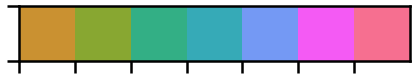

In [55]:
n_map = int(len(params[params['max nlog(p)'] > 1].index)) + 1
interval = 1 / n_map
husl_pal = sns.husl_palette(n_colors=n_map, h=interval)
husl_cmap = LinearSegmentedColormap.from_list(husl_pal, husl_pal, N=n_map)
sns.palplot(husl_pal)

crayons_l = sns.crayon_palette(['Vivid Tangerine', 'Cornflower'])
crayons_d = sns.crayon_palette(['Brick Red', 'Midnight Blue'])
grays = sns.light_palette('#999999', n_colors=3, reverse=True)

f_2 = sns.crayon_palette(['Red Orange', 'Vivid Tangerine'])
m_2 = sns.crayon_palette(['Cornflower', 'Cerulean'])

1 ('deltaPRI', 'post phys fci', 'iqXclass')
87 1.0
2 ('deltaPRI', 'post phys fci', 'fd')
11 2.0
118 2.0
122 2.0
123 2.0
127 2.0
128 2.0
15 2.0
158 2.0
159 2.0
161 2.0
163 2.0
168 2.0
170 2.0
173 2.0
174 2.0
20 2.0
218 2.0
226 2.0
23 2.0
24 2.0
242 2.0
248 2.0
258 2.0
259 2.0
264 2.0
35 2.0
40 2.0
44 2.0
61 2.0
77 2.0
84 2.0
88 2.0
89 2.0
91 2.0
3 ('deltaFSIQ', 'post phys fci', 'fd')
108 3.0
109 3.0
11 3.0
118 3.0
122 3.0
123 3.0
127 3.0
128 3.0
142 3.0
15 3.0
158 3.0
159 3.0
161 3.0
163 3.0
168 3.0
170 3.0
171 3.0
173 3.0
174 3.0
191 3.0
197 3.0
20 3.0
216 3.0
218 3.0
220 3.0
224 3.0
226 3.0
23 3.0
236 3.0
24 3.0
240 3.0
242 3.0
248 3.0
258 3.0
259 3.0
260 3.0
263 3.0
264 3.0
27 3.0
28 3.0
35 3.0
39 3.0
40 3.0
44 3.0
46 3.0
61 3.0
62 3.0
64 3.0
67 3.0
7 3.0
77 3.0
84 3.0
88 3.0
89 3.0
91 3.0
4 ('WMI2', 'post phys retr', 'sexXclass')
127 4.0
5 ('VCI2', 'post phys retr', 'Mod')
189 5.0
6 ('VCI2', 'post phys retr', 'fd')
1 6.0
11 6.0
188 6.0
20 6.0
227 6.0
34 6.0
50 6.0


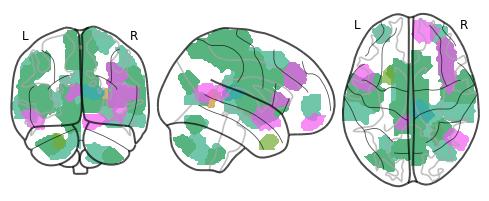

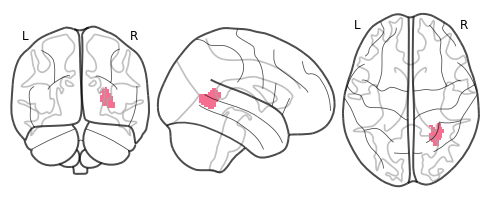

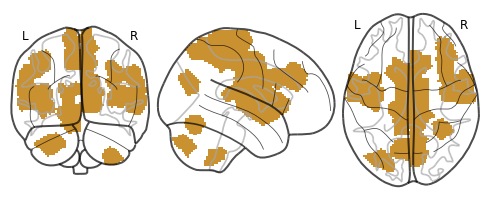

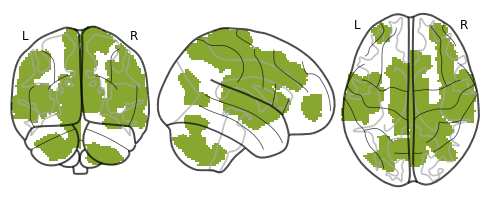

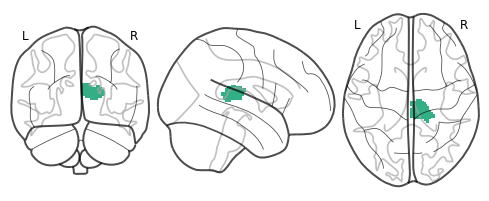

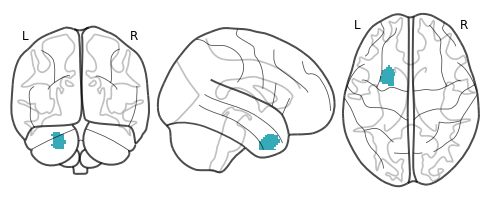

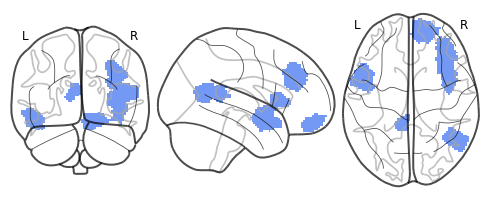

In [58]:
empty_nii = nib.load(join(roi_dir, 'roi101.nii.gz'))
empty_roi = empty_nii.get_fdata() * 0
empty = nib.Nifti1Image(empty_roi, empty_nii.affine)
g = plot_glass_brain(empty, colorbar=False, vmin=0.5, vmax=n_col)
i = 0


for var in params.index:
    if params.loc[var]['max nlog(p)'] > 1:
        i += 1
        husl_pal = sns.husl_palette(h=interval * i, n_colors=n_map)
        rois = None
        print(i, var)
        corr_nodes = []
        #tvals = params.loc[i]['max t']
        nodes = params.loc[var]['nodes']
        corr_nodes.append(int(nodes[0].strip('lEff')))
        roi_nifti = nib.load(join(roi_dir,'roi{0}.nii.gz'.format(int(nodes[0].strip('lEff')))))
        roi = roi_nifti.get_fdata()
        rois = (roi * i)
        print(int(nodes[0].strip('lEff')), np.max(rois))
        if len(nodes) > 1:
            for node in nodes[1:]:
                corr_nodes.append(int(node.strip('lEff')))
                roi_nifti = nib.load(join(roi_dir,'roi{0}.nii.gz'.format(int(node.strip('lEff')))))
                roi = roi_nifti.get_fdata()
                rois += (roi * i)
                print(int(node.strip('lEff')), np.max(rois))
        else:
            pass
        np.savetxt(join(fig_dir, '{1}-{0}.txt'.format(i, var)), corr_nodes, delimiter=',')
        rois_nifti = nib.Nifti1Image(rois, roi_nifti.affine)
        rois_nifti.to_filename(join(data_dir, 'output/local_efficiency', '{0}_nodes.nii.gz'.format(var)))
        h = plot_glass_brain(rois_nifti, cmap=LinearSegmentedColormap.from_list(husl_pal, husl_pal, N=3))
        h.savefig(join(fig_dir, '{0}-{1}_ROIs.png'.format(i, var)), dpi=300)
        
        husl_pal = sns.husl_palette(n_colors=int(n_map), h=interval*i)
        g.add_contours(rois_nifti, colors=husl_pal, filled=True, alpha=0.7)
        
    else:
        pass
    
g.savefig(join(fig_dir, 'LEffXIQ_ROIs.png'), dpi=300)

In [59]:
var

('VCI2', 'post phys retr', 'fd')

In [69]:
n_col = int(len(nodaleff_sig.columns)/2) + 1
husl_pal = sns.husl_palette(n_colors=int(n_col))
husl_cmap = LinearSegmentedColormap.from_list(husl_pal, husl_pal, N=int(n_col))
i = 0
for var in params.index:
    if params.loc[var]['max nlog(p)'] > 1:
        iq = var[0]
        task = var[1]
        dat = effs[task]['conns']
        husl_pal = sns.husl_palette(h=(interval*i), n_colors=int(n_col))

        print(var, i)
        all_data = pd.concat([big_df, dat[conns]], axis=1)
        all_data.dropna(how='any', axis=0, inplace=True)
        nodes = params.loc[var]['nodes']
        print(nodes)
        for node in nodes:
            if var[-1] == 'iqXsex':
                #print(iq, 'x Sex', node, nodaleff_sig.at[node,'{0}t'.format(var[:-1])])
                h = sns.lmplot(iq, node, data=all_data, hue='F', palette=crayons_d)
                h.savefig(join(fig_dir, '{0}-{1}-scatter.png'.format(i+1, var, node)), dpi=300)
                plt.close()
            elif var[-1] == 'iqXsexXclass':
                #print(iq, 'x Sex x Class', node,  nodaleff_sig.at[node,'{0}t'.format(var[:-1])])
                h = sns.lmplot(iq, node, data=all_data[all_data['F'] == 1], hue='Mod', palette=f_2)
                h.savefig(join(fig_dir, '{0}-{1}-scatter-f.png'.format(i, var, node)), dpi=300)
                h = sns.lmplot(iq, node, data=all_data[all_data['F'] == 0], hue='Mod', palette=m_2)
                h.savefig(join(fig_dir, '{0}-{1}-scatter-m.png'.format(i+1, var, node)), dpi=300)
                plt.close()
            elif var[-1] == 'iqXclass':
                #print(iq, 'x Class', node,  nodaleff_sig.at[node,'{0}t'.format(column[:-1])])
                h = sns.lmplot(iq, node, data=all_data, hue='Mod', palette=grays)
                h.savefig(join(fig_dir, '{0}-{1}-scatter.png'.format(i+1, var, node)), dpi=300)
                plt.close()
            elif var[-1] == 'sexXclass':
                #print('Sex x Class', node,  nodaleff_sig.at[node,'{0}t'.format(column[:-1])])
                h = sns.lmplot('F', node, data=all_data[all_data['F'] == 1], hue='Mod', palette=f_2)
                h.savefig(join(fig_dir, '{0}-{1}-scatter-.png'.format(i+1, var, node)), dpi=300)
                plt.close()
            elif var[-1] == 'iq':
                #print('no interxn', iq, node, nodaleff_sig.at[node,'{0}t'.format(column[:-1])])
                fig,ax = plt.subplots()
                sns.regplot(all_data[iq], all_data[node], color=husl_pal[0])
                sns.despine()
                plt.tight_layout()
                fig.savefig(join(fig_dir, '{0}-{1}-scatter.png'.format(i+1, var, node)), dpi=300)
                plt.close()
            elif var[-1] == 'fd':
                pass
            else:
                fig,ax = plt.subplots()
                sns.regplot(all_data[var[-1]], all_data[node], color=husl_pal[0])
                sns.despine()
                plt.tight_layout()
                fig.savefig(join(fig_dir, '{0}-{1}-scatter.png'.format(i+1, var, node)), dpi=300)
                plt.close()
        i += 1

('deltaPRI', 'post phys fci', 'iqXclass') 0
['lEff87']
('deltaPRI', 'post phys fci', 'fd') 1
['lEff11', 'lEff118', 'lEff122', 'lEff123', 'lEff127', 'lEff128', 'lEff15', 'lEff158', 'lEff159', 'lEff161', 'lEff163', 'lEff168', 'lEff170', 'lEff173', 'lEff174', 'lEff20', 'lEff218', 'lEff226', 'lEff23', 'lEff24', 'lEff242', 'lEff248', 'lEff258', 'lEff259', 'lEff264', 'lEff35', 'lEff40', 'lEff44', 'lEff61', 'lEff77', 'lEff84', 'lEff88', 'lEff89', 'lEff91']
('deltaFSIQ', 'post phys fci', 'fd') 2
['lEff108', 'lEff109', 'lEff11', 'lEff118', 'lEff122', 'lEff123', 'lEff127', 'lEff128', 'lEff142', 'lEff15', 'lEff158', 'lEff159', 'lEff161', 'lEff163', 'lEff168', 'lEff170', 'lEff171', 'lEff173', 'lEff174', 'lEff191', 'lEff197', 'lEff20', 'lEff216', 'lEff218', 'lEff220', 'lEff224', 'lEff226', 'lEff23', 'lEff236', 'lEff24', 'lEff240', 'lEff242', 'lEff248', 'lEff258', 'lEff259', 'lEff260', 'lEff263', 'lEff264', 'lEff27', 'lEff28', 'lEff35', 'lEff39', 'lEff40', 'lEff44', 'lEff46', 'lEff61', 'lEff62', 'lE